In [1]:
%matplotlib qt5
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.ndimage.interpolation import shift
from scipy.signal import decimate
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import pickle


In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def rolling_zscore(x, window=10*10000):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [3]:
mouse = 'SNL_photo17'
date = '20200204'
saving_folder = 'W:\\photometry_2AC\\processed_data\\' + mouse + '\\'
restructured_data_filename = mouse + '_' + date + '_' + 'restructured_data.pkl'
trial_data = pd.read_pickle(saving_folder + restructured_data_filename) 
dff_trace_filename = mouse + '_' + date + '_' + 'smoothed_signal.npy'
dff = np.load(saving_folder + dff_trace_filename)

In [4]:
window_size_seconds = 10
sample_rate = 10000
decimate_factor = 100

In [5]:
rolling_zscored_dff = rolling_zscore(pd.Series(dff), window=window_size_seconds*sample_rate)

In [6]:
rolling_zscored_dff.shape

(45755000,)

In [7]:
downsampled_zscored_dff = decimate(decimate(rolling_zscored_dff[window_size_seconds*sample_rate:], int(decimate_factor/10)), int(decimate_factor/10))

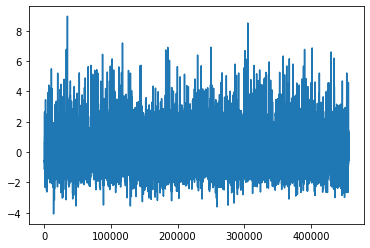

In [11]:
plt.plot(downsampled_zscored_dff)

In [8]:
num_samples = downsampled_zscored_dff.shape[0]

In [9]:
def turn_timestamps_into_continuous(num_samples, *behavioural_events):
    continuous_parameters = []
    for event_type_timestamps in behavioural_events:
        continuous_time_version = np.zeros([num_samples])
        continuous_time_version[event_type_timestamps] = 1
        continuous_parameters.append(continuous_time_version)
    return continuous_parameters

In [10]:
aligned_filename = mouse + '_' + date + '_' + 'behavioural_events.p'
save_filename = saving_folder + aligned_filename
example_session_data = pickle.load(open(save_filename, "rb"))

In [11]:
def convert_behavioural_timestamps_into_samples(time_stamps, window_to_remove, sample_rate=10000, decimate_factor=100):
    return np.round((time_stamps - window_size_seconds)*sample_rate/decimate_factor).astype(int)

In [15]:
ipsi_choices = convert_behavioural_timestamps_into_samples(example_session_data.choice_data.ipsi_data.event_times, window_size_seconds)
contra_choices = convert_behavioural_timestamps_into_samples(example_session_data.choice_data.contra_data.event_times, window_size_seconds)
ipsi_cues = convert_behavioural_timestamps_into_samples(example_session_data.cue_data.ipsi_data.event_times, window_size_seconds)
contra_cues = convert_behavioural_timestamps_into_samples(example_session_data.cue_data.contra_data.event_times, window_size_seconds)
ipsi_rewards = convert_behavioural_timestamps_into_samples(example_session_data.reward_data.ipsi_data.event_times, window_size_seconds)
contra_rewards = convert_behavioural_timestamps_into_samples(example_session_data.reward_data.contra_data.event_times, window_size_seconds)

In [25]:
ipsi_cues

array([ 12001,  49196,  59685,  76222,  84411,  86665,  96367,  98181,
       100520, 100974, 104084, 149399, 153665, 157816, 158834, 163618,
       207688, 209465, 214590, 215210, 218862, 219436, 221438, 223130,
       225099, 225968, 234828, 236406, 238347, 239989, 311279, 317848,
       320236, 321103, 329302, 333892, 336848, 340153, 343338, 347151,
       348195, 350172, 351416, 354351, 358010, 358886, 362899, 366580,
       370392, 371118, 375044, 390275, 394748, 396392, 397136, 398315,
       402652, 406427, 408016, 410423, 411933, 412469, 417197, 419555,
       421766, 422314, 426411, 427657, 429415, 431866, 432333, 432898,
       433677, 434155, 436185, 437751, 438342, 439185, 440912, 442376,
       454223])

In [26]:
all_cues = np.concatenate([ipsi_cues, contra_cues])
all_rewards = np.concatenate([ipsi_rewards, contra_rewards])

In [16]:
parameters = turn_timestamps_into_continuous(num_samples, ipsi_choices, contra_choices, ipsi_cues, contra_cues, ipsi_rewards, contra_rewards)

In [27]:
parameters = turn_timestamps_into_continuous(num_samples, ipsi_choices, contra_choices, all_cues, all_rewards)

In [28]:
plt.plot(parameters[5])

IndexError: list index out of range

In [29]:
def make_design_matrix(parameters, window_min=-1*10000/100, window_max=2*10000/100):
    num_parameters = len(parameters)
    shifts = np.arange(window_min, window_max + 1)
    shift_window_size = shifts.shape[0]
    X = np.zeros([parameters[0].shape[0], shift_window_size*num_parameters])
    all_param_indices = []
    for shift_num, shift_val in  enumerate(shifts):
        for param_num, param in enumerate(parameters):
            param_indices = range(param_num*shift_window_size, param_num*shift_window_size + shift_window_size)
            all_param_indices.append(param_indices)
            shifted_param = shift(param, shift_val, cval=0) 
            X[:, param_indices[shift_num]] = shifted_param
    return(all_param_indices, X)


In [30]:
all_param_indices, X = make_design_matrix(parameters)

In [31]:
results = LinearRegression().fit(X, downsampled_zscored_dff)

In [21]:
def plot_kernels(parameter_names, regression_results,window_min=-1*10000/100, window_max=2*10000/100):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(parameter_names), sharey=True, figsize=(15,8))
    
    shifts = np.arange(window_min, window_max + 1)
    shift_window_size = shifts.shape[0]
    for param_num, param_name in enumerate(parameter_names):
        param_kernel = regression_results.coef_[param_num*shift_window_size:(param_num+1)*shift_window_size]
        axs[param_num].plot(shifts, param_kernel, label=param_name)
        axs[param_num].set_title(param_name)

In [22]:
param_names = ['ipsi choices', 'contra choices', 'ipsi cues', 'contra cues', 'ipsi rewards', 'contra rewards']
plot_kernels(param_names, results)

In [33]:
param_names = ['ipsi choices', 'contra choices','cues', 'rewards']
plot_kernels(param_names, results)

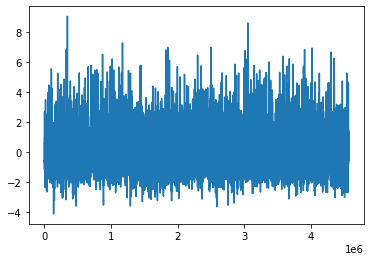

In [50]:
plt.plot(downsampled_zscored_dff)